# 4 
## 4.1 **准自然实验设计：干旱事件 + 双重差分（DiD）**

本研究以2010年干旱作为处理组识别事件，将县份分为“严重干旱组”（SPEI≤–1）与“轻微干旱组”（SPEI > –1）进行对比分析。采用固定效应面板回归模型

In [1]:
# 导入相关库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

In [2]:
import geopandas as gpd

In [18]:
df = pd.read_csv("data/guizhou_panel_cleaned.csv")

### 4.1.1 构造变量

In [19]:
# === 步骤 1：构造县份唯一ID ===
df['county_id'] = df['ENG_NAME'].astype('category').cat.codes

# === 步骤 2：构造 post 与 event time ===
df['post_2010'] = (df['year'] >= 2010).astype(int)
df['event_time'] = df['year'] - 2010

# === 步骤 3：构造处理组变量 drought_treated ===
# 逻辑：drought_class ≥ 2 的县为“干旱县”，固定在所有年份标记
treated_counties = df[(df['year'] == 2010) & (df['drought_class'] >= 2)]['ENG_NAME'].unique()
df['drought_treated'] = df['ENG_NAME'].isin(treated_counties).astype(int)

# === 步骤 4：构造 DiD 交互项 ===
df['drought_post'] = df['drought_treated'] * df['post_2010']

# === 步骤 5：构造空间异质性变量（农业依赖） ===
# cropland_pct 高于全样本 75% 为高依赖农业县
threshold = df['cropland_pct'].quantile(0.75)
df['high_agriculture'] = (df['cropland_pct'] >= threshold).astype(int)

# === 步骤 6：构造交互项（异质性分析用） ===
df['drought_post_high_agri'] = df['drought_post'] * df['high_agriculture']

#### 检查

In [20]:
# 检查所有变量是否存在
print(df.columns)

# 检查关键变量的数据类型与是否有缺失
df[['county_id', 'drought_treated', 'post_2010', 'event_time',
    'drought_post', 'high_agriculture', 'drought_post_high_agri']].info()

Index(['ENG_NAME', 'year', 'ndvi_all', 'ndvi_crop', 'rain_gs', 'drought_class',
       'drought_pixel_rate', 'median', 'cropland_pct', 'county_id',
       'post_2010', 'event_time', 'drought_treated', 'drought_post',
       'high_agriculture', 'drought_post_high_agri'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   county_id               440 non-null    int8 
 1   drought_treated         440 non-null    int64
 2   post_2010               440 non-null    int64
 3   event_time              440 non-null    int64
 4   drought_post            440 non-null    int64
 5   high_agriculture        440 non-null    int64
 6   drought_post_high_agri  440 non-null    int64
dtypes: int64(6), int8(1)
memory usage: 21.2 KB


In [ ]:
# 处理组数量（drought_treated=1）
df[['ENG_NAME', 'drought_treated']].drop_duplicates()['drought_treated'].value_counts()

drought_treated
0    48
1    40
Name: count, dtype: int64

In [22]:
df.groupby(['year', 'drought_treated']).size()

year  drought_treated
2008  0                  48
      1                  40
2009  0                  48
      1                  40
2010  0                  48
      1                  40
2011  0                  48
      1                  40
2012  0                  48
      1                  40
dtype: int64

In [23]:
# 交互逻辑验证——检查 drought_treated × post_2010 生成的交互项是否正确
df[['drought_treated', 'post_2010', 'drought_post']].drop_duplicates()

,drought_treated,post_2010,drought_post
0,1,0,0
1,0,0,0
176,1,1,1
177,0,1,0


In [24]:
# 查看高农业依赖县数量（前25%）
df[['ENG_NAME', 'high_agriculture']].drop_duplicates()['high_agriculture'].value_counts()

high_agriculture
0    66
1    22
Name: count, dtype: int64

In [25]:
# 事件时间分布
df['event_time'].value_counts().sort_index()

event_time
-2    88
-1    88
 0    88
 1    88
 2    88
Name: count, dtype: int64

In [26]:
# === 步骤 7：保存处理后的数据 ===
df.to_csv("data/guizhou_model_ready.csv", index=False)

### 可视化受灾县

### 构造异质性检验变量

#### 1. NDVI 基准值（2008–2009 平均）

In [ ]:
# 读取处理后的数据
df_ready = pd.read_csv("data/guizhou_model_ready.csv")

# 按县计算2008–2009年ndvi_crop均值
ndvi_baseline = df_ready[df_ready['year'].isin([2008, 2009])].groupby('ENG_NAME')['ndvi_crop'].mean().reset_index()
ndvi_baseline.rename(columns={'ndvi_crop': 'ndvi_baseline'}, inplace=True)

# 合并进主表
df_ready = df_ready.merge(ndvi_baseline, on='ENG_NAME', how='left')

# 构造高/低NDVI dummy
threshold = df_ready['ndvi_baseline'].quantile(0.75)
df_ready['high_ndvi'] = (df_ready['ndvi_baseline'] >= threshold).astype(int)

# 可用于交互项
df_ready['drought_post_high_ndvi'] = df_ready['drought_post'] * df_ready['high_ndvi']

#### 2. 高海拔 dummy（>1500m）


In [32]:
elev_df = pd.read_csv("data/guizhou_high_elevation_export.csv")
elev_df['high_elevation'] = elev_df['high_elevation'].astype(int)  # 转为数值型

# 合并到主数据
df_ready = df_ready.merge(elev_df, on="ENG_NAME", how="left")

In [33]:
# 构造交互项
df_ready['drought_post_high_elev'] = df_ready['drought_post'] * df_ready['high_elevation']

#### 3. 2000年人口

In [39]:
gdf = gpd.read_file("data/guizhou_county_shp/guizhou_county.shp")
# 假设 gdf 是你的 GeoDataFrame，含中文和英文名
county_name_map = gdf[['地名', 'ENG_NAME']].drop_duplicates()
county_name_map.columns = ['county_name', 'ENG_NAME']

In [40]:
# 1. 读取人口密度表
pop_df = pd.read_csv("data/guizhou_pop_2000.csv") 

In [ ]:
# 合并中英县名
pop_df = pop_df.merge(county_name_map, on='county_name', how='left')

# 合并人口密度到主面板数据 df_ready
df_ready = df_ready.merge(pop_df[['ENG_NAME', 'pop_density_2000']], on='ENG_NAME', how='left')

# 构造 dummy 和交互项
threshold = df_ready['pop_density_2000'].quantile(0.75)
df_ready['high_density'] = (df_ready['pop_density_2000'] >= threshold).astype(int)
df_ready['drought_post_high_density'] = df_ready['drought_post'] * df_ready['high_density']

#### 检查交互项

In [ ]:
df_ready[['drought_post_high_agri', 'drought_post_high_ndvi', 'drought_post_high_density']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   drought_post_high_agri     440 non-null    int64
 1   drought_post_high_ndvi     440 non-null    int64
 2   drought_post_high_density  440 non-null    int64
dtypes: int64(3)
memory usage: 10.4 KB


In [43]:
for col in ['drought_post_high_agri', 'drought_post_high_ndvi', 'drought_post_high_density']:
    print(col)
    print(df_ready[col].value_counts(), "\n")

drought_post_high_agri
drought_post_high_agri
0    395
1     45
Name: count, dtype: int64 

drought_post_high_ndvi
drought_post_high_ndvi
0    413
1     27
Name: count, dtype: int64 

drought_post_high_density
drought_post_high_density
0    416
1     24
Name: count, dtype: int64 



In [44]:
df_ready[df_ready['drought_post_high_ndvi'] == 1][['year', 'drought_treated', 'post_2010', 'high_ndvi']].drop_duplicates()

,year,drought_treated,post_2010,high_ndvi
178,2010,1,1,1
266,2011,1,1,1
354,2012,1,1,1


e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\study\CASA_disser

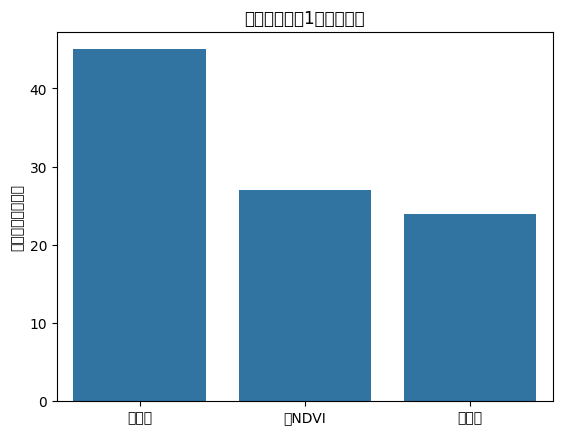

In [ ]:
# 简单条形图：看三个交互项中有多少个 1
counts = {
    "高农业": df_ready['drought_post_high_agri'].sum(),
    "高NDVI": df_ready['drought_post_high_ndvi'].sum(),
    "高密度": df_ready['drought_post_high_density'].sum()
}

sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title("交互项中值为1的样本数量")
plt.ylabel("样本数（条目数）")
plt.show()

In [46]:
df_ready.to_csv("data/guizhou_model_ready.csv", index=False)

### 处理建模前的表格

In [48]:
# 重命名密度字段统一命名
df_ready = df_ready.rename(columns={'pop_density_2000_x': 'pop_density_2000'})

# 删除冗余列
drop_cols = ['ndvi_all', 'median', 'system:index', '.geo', 'pop_density_2000_y']
df_ready = df_ready.drop(columns=drop_cols)

# 补全缺失
df_ready['ndvi_crop'] = df_ready['ndvi_crop'].fillna(0)
df_ready['ndvi_baseline'] = df_ready['ndvi_baseline'].fillna(0)

# 导出干净建模表
df_ready.to_csv("data/guizhou_model_clean.csv", index=False)


In [50]:
df_cleaned = pd.read_csv ("data/guizhou_model_clean.csv")
# 1. 补齐 pop_density_2000
mean_density = df_cleaned['pop_density_2000'].mean()
df_cleaned['pop_density_2000'] = df_cleaned['pop_density_2000'].fillna(mean_density)

# 2. 重新划定 high_density（建议使用更新后的分布）
threshold = df_cleaned['pop_density_2000'].quantile(0.75)
df_cleaned['high_density'] = (df_cleaned['pop_density_2000'] >= threshold).astype(int)

# 3. 重构交互项
df_cleaned['drought_post_high_density'] = df_cleaned['drought_post'] * df_cleaned['high_density']

In [51]:
df_cleaned.to_csv("data/guizhou_model_clean2.csv", index=False)

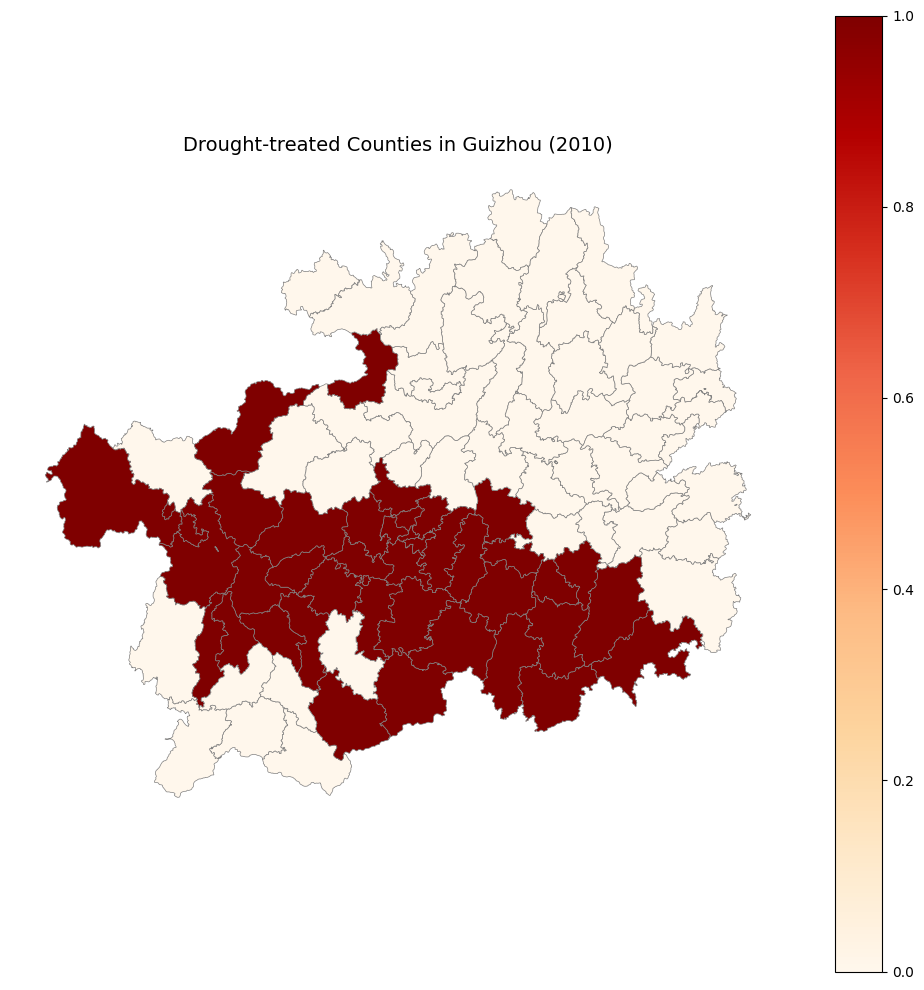

In [28]:
# === 1. 读取地理边界数据（贵州县级 shapefile）===
gdf = gpd.read_file("data/guizhou_county_shp/guizhou_county.shp")

# 确保有一列县名与你的 df 对应，例如 county_en 或 county_name
# 如需重命名，可使用：
# gdf = gdf.rename(columns={"NAME_EN": "ENG_NAME"})

# === 2. 读取模型数据 ===
df = pd.read_csv("data/guizhou_model_ready.csv")

# 取出 2010 年县名 + drought_treated 标签，去重
df_drought = df[df['year'] == 2010][['ENG_NAME', 'drought_treated']].drop_duplicates()

# === 3. 合并地图和数据 ===
gdf = gdf.merge(df_drought, on="ENG_NAME", how="left")

# 如果某些县未匹配到，则设为 0（默认非干旱县）
gdf['drought_treated'] = gdf['drought_treated'].fillna(0)

# === 4. 可视化 ===
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='drought_treated',
         cmap='OrRd', linewidth=0.5, edgecolor='gray',
         legend=True, ax=ax)

ax.set_title("Drought-treated Counties in Guizhou (2010)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

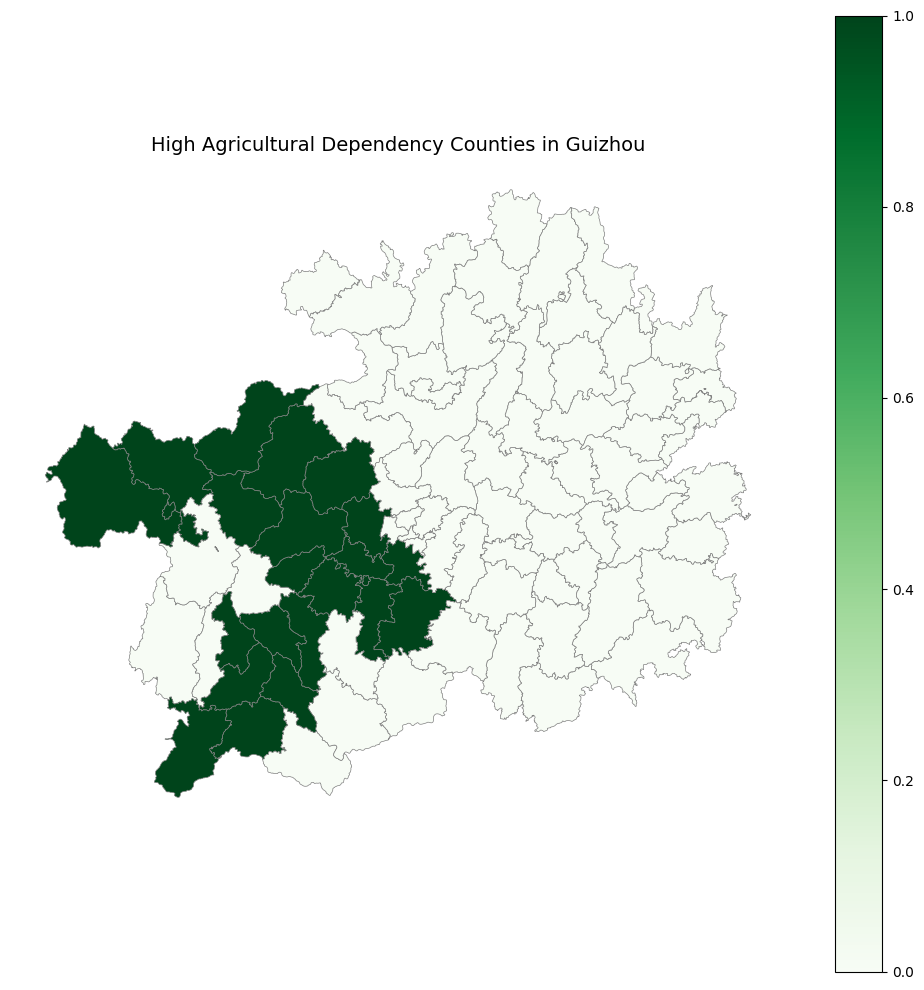

In [30]:
# 高农业依赖县
# === 1. 读取地图数据 ===
# === 2. 读取模型数据 ===

# 取唯一县 + 农业依赖标签（避免重复）
df_agri = df[['ENG_NAME', 'high_agriculture']].drop_duplicates()

# === 3. 合并地图和属性数据 ===
gdf = gdf.merge(df_agri, on="ENG_NAME", how="left")
gdf['high_agriculture'] = gdf['high_agriculture'].fillna(0)

# === 4. 画图 ===
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='high_agriculture',
         cmap='Greens', linewidth=0.5, edgecolor='gray',
         legend=True, ax=ax)

ax.set_title("High Agricultural Dependency Counties in Guizhou", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


## 4.2 DiD

### 4.2.0 女娲补天，搞忘合并人口数据

略

### 4.2.1 基础模型代码

In [ ]:
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

In [67]:
# 加载数据
df = pd.read_csv("data/guizhou_model.csv")

# 删除主要结果变量缺失的观测
df_model = df.dropna(subset=['net_migration_per_1000', 'ndvi_crop'])

In [69]:
import statsmodels.formula.api as smf

# 模型 1：干旱对净迁移率的影响
model_mig = smf.ols(
    formula="net_migration_per_1000 ~ drought_post + C(county_id) + C(year)",
    data=df_model
).fit(cov_type='cluster', cov_kwds={'groups': df_model['county_id']})

# 模型 2：干旱对农业活力（NDVI）的影响
model_ndvi = smf.ols(
    formula="ndvi_crop ~ drought_post + C(county_id) + C(year)",
    data=df_model
).fit(cov_type='cluster', cov_kwds={'groups': df_model['county_id']})

# 打印结果
print(model_mig.summary())
print(model_ndvi.summary())


                              OLS Regression Results                              
Dep. Variable:     net_migration_per_1000   R-squared:                       0.459
Model:                                OLS   Adj. R-squared:                  0.313
Method:                     Least Squares   F-statistic:                     196.2
Date:                    Tue, 29 Jul 2025   Prob (F-statistic):           1.91e-41
Time:                            18:49:21   Log-Likelihood:                -1570.6
No. Observations:                     416   AIC:                             3319.
Df Residuals:                         327   BIC:                             3678.
Df Model:                              88                                         
Covariance Type:                  cluster                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 88, but rank is 4
  warnings.warn('covariance of constraints does not have full '
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 88, but rank is 5
  warnings.warn('covariance of constraints does not have full '


### 4.2.2 Event Study

#### 1. 迁移数据

In [72]:
import statsmodels.formula.api as smf

# 回归：事件研究 + 固定效应 + 聚类稳健标准误
event_model = smf.ols(
    formula="net_migration_per_1000 ~ C(event_time) * drought_treated + C(county_id) + C(year)",
    data=df_model
).fit(cov_type='cluster', cov_kwds={'groups': df_model['county_id'].values})

In [76]:
import re
import pandas as pd

# 修正后的提取逻辑：匹配交互项字符串
event_coefs = event_model.params[event_model.params.index.str.contains("event_time") & event_model.params.index.str.contains(":drought_treated")]
conf_int = event_model.conf_int().loc[event_coefs.index]

# 提取事件年份（τ）
import re
event_years = [int(re.search(r'C\(event_time\)\[T\.(-?\d+)\]', name).group(1)) for name in event_coefs.index]

# 构建绘图数据框
import pandas as pd
event_df = pd.DataFrame({
    'year': event_years,
    'coef': event_coefs.values,
    'ci_low': conf_int[0].values,
    'ci_high': conf_int[1].values
}).sort_values('year')


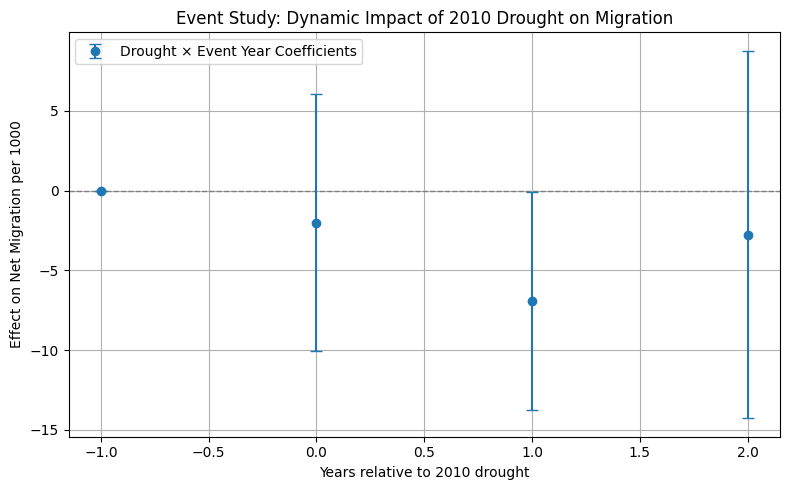

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.errorbar(event_df['year'], event_df['coef'],
             yerr=[event_df['coef'] - event_df['ci_low'], event_df['ci_high'] - event_df['coef']],
             fmt='o', capsize=4, label='Drought × Event Year Coefficients')

plt.xlabel("Years relative to 2010 drought")
plt.ylabel("Effect on Net Migration per 1000")
plt.title("Event Study: Dynamic Impact of 2010 Drought on Migration")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [75]:
print(event_model.params.index.tolist())


['Intercept', 'C(event_time)[T.-1]', 'C(event_time)[T.0]', 'C(event_time)[T.1]', 'C(event_time)[T.2]', 'C(county_id)[T.1]', 'C(county_id)[T.2]', 'C(county_id)[T.4]', 'C(county_id)[T.5]', 'C(county_id)[T.6]', 'C(county_id)[T.7]', 'C(county_id)[T.8]', 'C(county_id)[T.9]', 'C(county_id)[T.10]', 'C(county_id)[T.11]', 'C(county_id)[T.12]', 'C(county_id)[T.13]', 'C(county_id)[T.14]', 'C(county_id)[T.15]', 'C(county_id)[T.16]', 'C(county_id)[T.17]', 'C(county_id)[T.18]', 'C(county_id)[T.19]', 'C(county_id)[T.20]', 'C(county_id)[T.21]', 'C(county_id)[T.22]', 'C(county_id)[T.23]', 'C(county_id)[T.24]', 'C(county_id)[T.25]', 'C(county_id)[T.26]', 'C(county_id)[T.27]', 'C(county_id)[T.28]', 'C(county_id)[T.29]', 'C(county_id)[T.30]', 'C(county_id)[T.31]', 'C(county_id)[T.32]', 'C(county_id)[T.33]', 'C(county_id)[T.34]', 'C(county_id)[T.35]', 'C(county_id)[T.36]', 'C(county_id)[T.37]', 'C(county_id)[T.38]', 'C(county_id)[T.39]', 'C(county_id)[T.40]', 'C(county_id)[T.41]', 'C(county_id)[T.44]', 'C(

#### 2. NDVI

In [ ]:
# 回归模型：NDVI ~ 干旱组 × 事件年份 + 双固定效应 + 县级聚类稳健标准误
ndvi_event_model = smf.ols(
    formula="ndvi_crop ~ C(event_time) * drought_treated + C(county_id) + C(year)",
    data=df_model
).fit(cov_type='cluster', cov_kwds={'groups': df_model['county_id'].values})

In [79]:
# 提取干旱 × 事件年份交互项系数
ndvi_event_coefs = ndvi_event_model.params[
    ndvi_event_model.params.index.str.contains("event_time") & 
    ndvi_event_model.params.index.str.contains(":drought_treated")
]
ndvi_conf_int = ndvi_event_model.conf_int().loc[ndvi_event_coefs.index]

# 提取事件年份（τ）
ndvi_event_years = [int(re.search(r'C\(event_time\)\[T\.(-?\d+)\]', name).group(1)) for name in ndvi_event_coefs.index]

# 整理成绘图 DataFrame
ndvi_event_df = pd.DataFrame({
    'year': ndvi_event_years,
    'coef': ndvi_event_coefs.values,
    'ci_low': ndvi_conf_int[0].values,
    'ci_high': ndvi_conf_int[1].values
}).sort_values('year')

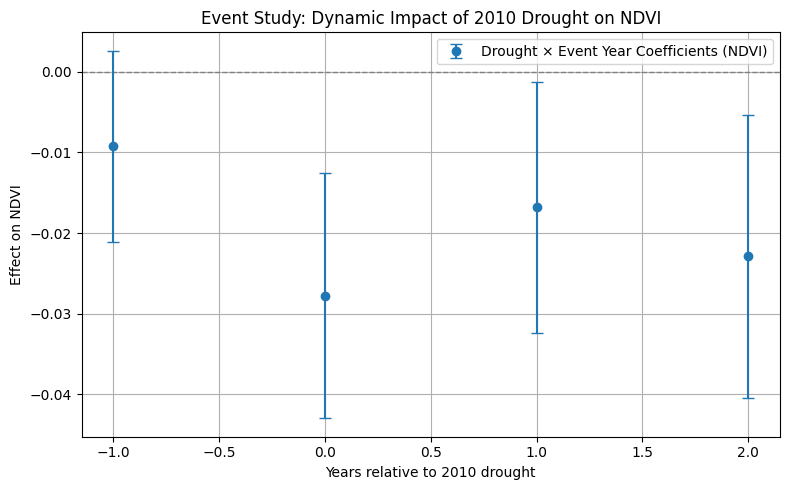

In [80]:
plt.figure(figsize=(8, 5))
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.errorbar(ndvi_event_df['year'], ndvi_event_df['coef'],
             yerr=[ndvi_event_df['coef'] - ndvi_event_df['ci_low'],
                   ndvi_event_df['ci_high'] - ndvi_event_df['coef']],
             fmt='o', capsize=4, label='Drought × Event Year Coefficients (NDVI)')

plt.xlabel("Years relative to 2010 drought")
plt.ylabel("Effect on NDVI")
plt.title("Event Study: Dynamic Impact of 2010 Drought on NDVI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 4.2.3 异质性分析

#### 1. high_density

In [82]:
for z in ['high_density', 'high_elev', 'urban_core']:
    df_model[f'drought_post_{z}'] = df_model['drought_post'] * df_model[z]
    formula = f"net_migration_per_1000 ~ drought_post + drought_post_{z} + C(county_id) + C(year)"
    model = smf.ols(formula=formula, data=df_model).fit(cov_type='cluster', cov_kwds={'groups': df_model['county_id'].values})
    print(f"\n--- Heterogeneity: {z} ---")
    print(model.summary().tables[1])



--- Heterogeneity: high_density ---
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     3.0931      1.871      1.654      0.098      -0.573       6.759
C(county_id)[T.1]             3.2919      2.503      1.315      0.188      -1.613       8.197
C(county_id)[T.2]           -19.4240   9.41e-14  -2.06e+14      0.000     -19.424     -19.424
C(county_id)[T.4]            -4.2720   8.67e-14  -4.93e+13      0.000      -4.272      -4.272
C(county_id)[T.5]            -6.2400   9.73e-14  -6.42e+13      0.000      -6.240      -6.240
C(county_id)[T.6]            -4.7721      2.503     -1.907      0.057      -9.677       0.133
C(county_id)[T.7]            -4.8320   9.09e-14  -5.31e+13      0.000      -4.832      -4.832
C(county_id)[T.8]            -1.3641      2.503     -0.545      0.586      -6.269       3.541
C(county_id)[T.9]      

C:\Users\10851\AppData\Local\Temp\ipykernel_20800\2863788471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[f'drought_post_{z}'] = df_model['drought_post'] * df_model[z]
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 89, but rank is 5
  warnings.warn('covariance of constraints does not have full '
C:\Users\10851\AppData\Local\Temp\ipykernel_20800\2863788471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

#### 4.2.3 改进中 